In [1]:
import os

import pandas as pd

import numpy as np
from numpy import random

from random import sample

import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage.feature import daisy, hog, ORB, local_binary_pattern, SIFT
from skimage.color import label2rgb, rgb2gray
from skimage.transform import resize, rotate, downscale_local_mean

from scipy import ndimage as ndi
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from skimage import exposure

# from tqdm import tqdm

import gc

from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from sklearn.preprocessing import Normalizer
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

from scipy.special import erfcinv

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

import math

In [4]:
class GaborFilter:
    # constructor
    def __init__(self):
        # private members
        self.__Frequency = None # frequency of the filter
        self.__MaxFrequency = None # maximum frequency of the whole filter bank
        self.__Orientation = None # orientation of the filter
        self.__Envelope = None # the Gaussian part of the Gabor filter equations
        self.__FrequencyFilter = None # the Gabor filter on frequency domain
        self.__SpatialFilter = None # the Gabor filter on spatial domain
        self.__Domain = 1 #  "1" is intepreted as frequency domain; "0" encoded spatial domain

    @property # first decorate the getter method
    def frequency(self): # This getter method name is *the* name
        return self.__Frequency
    @frequency.setter    # the property decorates with `.setter` now
    def frequency(self, value):   # name, e.g. "attribute", is the same
        self.__Frequency = value   # the "value" name isn't special
    
    @property 
    def max_frequency(self): 
        return self.__MaxFrequency
    @max_frequency.setter 
    def max_frequency(self, value):   
        self.__MaxFrequency = value
        
    @property 
    def orientation(self): 
        return self.__Orientation
    @orientation.setter 
    def orientation(self, value):   
        self.__Orientation = value   
        
    @property 
    def envelope(self): 
        return self.__Envelope
    @envelope.setter 
    def envelope(self, value):   
        self.__Envelope = value   

    @property 
    def FrequencyDomainGaborFilter(self): 
        return self.__FrequencyFilter
    @FrequencyDomainGaborFilter.setter 
    def FrequencyDomainGaborFilter(self, value):   
        self.__FrequencyFilter = value   

    @property 
    def SpatialDomainGaborFilter(self): 
        return self.__SpatialFilter
    @SpatialDomainGaborFilter.setter 
    def SpatialDomainGaborFilter(self, value):   
        self.__SpatialFilter = value       
    
    @property 
    def FilterDomain(self): 
        return self.__Domain
    @FilterDomain.setter 
    def FilterDomain(self, value):   
        self.__Domain = value
        
    @staticmethod    
    def __norminv(self, p, mu, sigma):
    
        x0 = np.multiply( -np.sqrt(2), (erfcinv(2 * p)) );
        x = np.multiply(sigma, x0) + mu;

        return x
    
    
    def __compute_fhigh(self, a, b):
        
        f0 = self.frequency
        
        d = f0;

        if b > a:
            
            foo = -( (a**2) * d )/(a**2 - b**2)
            
            if foo < a:
                fhigh2 = np.sqrt( (d + foo)**2 + (b/a * np.sqrt(a**2 - foo**2))**2 )
            else:
                fhigh2 = d + a;
        
        else:
            fhigh2 = d + a; 

        if fhigh2 > 0.5:
            fhigh2 = 0.5; 

        self.max_frequency = fhigh2
    
    @staticmethod
    def __ellipsoid_envelope_point(self, a, b, c):

        x = (c * (a**2)) / np.sqrt(b**2 + c**2 * a**2)
        y = b / a * np.sqrt(a**2 - x**2);

        return np.array([x,y])
    
    
    def __accurate_envelope_f(self, a, b):
        
        f0 = self.frequency
        theta = self.orientation
        
        if np.mod(theta, np.pi/2)!=0:

            # solve points with slopes -tan(pi/2-theta) and tan(theta)
            x1y1 = self.__ellipsoid_envelope_point(a, b, -np.tan(np.pi/2-theta))
            x2y2 = self.__ellipsoid_envelope_point(a, b, np.tan(theta))

            envelope = np.array([x1y1, -x1y1, x2y2, -x2y2])

            # shift by f0
            envelope = envelope + np.tile([f0, 0],[4,1])

            # rotate by theta
            envelope = np.matmul(envelope, np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]))

            xmin = min(envelope[:,0]);
            xmax = max(envelope[:,0]);
            ymin = min(envelope[:,1]);
            ymax = max(envelope[:,1]);

            envelope = np.real([xmin, xmax, ymin, ymax])

        else: 

            envelope = np.array([[f0 - a, 0], [f0 + a, 0] , [f0, b], [f0, -b]])

            envelope = np.matmul(envelope, np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]))

            xmin = min(envelope[:,0]);
            xmax = max(envelope[:,0]);
            ymin = min(envelope[:,1]);
            ymax = max(envelope[:,1]);

            envelope=np.real([xmin, xmax, ymin, ymax])

        return envelope
    
    
    def transform_from_frequency_to_spatial_domain(self, row, col):
        
        envelope = self.envelope
        FrequencyGaborFilter = self.FrequencyDomainGaborFilter
        
        M1 = col
        M2 = row

        lx = envelope[1] - envelope[0];
        ly = envelope[3] - envelope[2];

        xx = np.int32(np.mod( np.arange(0,lx + 1) + envelope[0] + M1 , M1 ) + 1)-1;
        yy = np.int32(np.mod( np.arange(0,ly + 1) + envelope[2] + M2 , M2 ) + 1)-1;

        f2_ = np.zeros((M2,M1), dtype=np.float64)

        for y in range(0,len(yy)):
            for x in range(0,len(xx)):
                xf2 = xx[x] 
                yf2 = yy[y] 

                f2_[yf2,xf2] = FrequencyGaborFilter[y,x]

        f2 = np.fft.ifftshift( np.fft.ifft2(f2_) )

        self.SpatialDomainGaborFilter = f2
    
    
    def compute_a_gabor_filter(self, gamma, eta, row, col, domain=1):
        
        Nx = col
        Ny = row
        
        f0 = self.frequency
        theta = self.orientation
        
        pf = np.sqrt(0.99) #energy to include in the filters
        alpha = f0 / gamma
        beta = f0 / eta

        # accurate rectangular envelope
        majenv = self.__norminv(np.array([1-pf, 1+pf])/2, 0, f0/(np.sqrt(2)*np.pi*gamma))
        minenv = self.__norminv(np.array([1-pf, 1+pf])/2, 0, f0/(np.sqrt(2)*np.pi*eta))

        self.__compute_fhigh(majenv[1],minenv[1])

        envelope = self.__accurate_envelope_f(majenv[1],minenv[1])

        envelope[:2] = envelope[:2] * Nx
        envelope[-2:] = envelope[-2:] * Ny

        envelope = np.array([np.floor(envelope[0]), np.ceil(envelope[1]), np.floor(envelope[2]), np.ceil(envelope[3])])

        nx = np.arange(envelope[0], envelope[1] + 1, 1, dtype=int)
        ny = np.arange(envelope[2], envelope[3] + 1, 1, dtype=int)

        u = nx / Nx; #frequencies that bank contains
        v = ny / Ny;

        U, V = np.meshgrid(u,v)

        Uenvelope =  (np.add(-U * np.sin(theta), V * np.cos(theta)))**2 / beta**2
        Venvelope =  (np.add(U * np.cos(theta), V * np.sin(theta) - f0))**2 / alpha**2

        gf = np.exp( -(np.pi**2) * np.add(Uenvelope,Venvelope) )
        
        self.FrequencyDomainGaborFilter = gf
        self.envelope = envelope
        
        self.transform_from_frequency_to_spatial_domain(row, col)

    
    def show_parameters(self):
        print("This Gabor filter has: \n", "\t frequency:",self.frequency,
                                            "\n\t orientation:", self.orientation,
                                            "\n\t max frequency:", self.max_frequency,
                                            "\n\t Gaussian envelope:", self.envelope,                        
                                            "\n\t shape on frequency domain:", self.FrequencyDomainGaborFilter.shape,             
                                            "\n\t shape on spatial domain:", self.SpatialDomainGaborFilter.shape)
    


In [5]:
def solve_k(gamma, p):

        x = 1.0 / (gamma * np.pi)*np.sqrt(-np.log(p));
        k = (1 + x) / (1 - x);

        return k


def solve_p(gamma, k):

    p = np.exp(- (gamma * np.pi * (k - 1) / (k + 1))**2);

    return p


def solve_gamma(k, p):

    gamma = 1.0 / np.pi * np.sqrt(-np.log(p)) * (k + 1) / (k - 1);

    return gamma


def solve_eta(n, p):

    ua = np.pi / n / 2; # ua based on approximation

    eta = 1.0 / np.pi * np.sqrt(-np.log(p)) / ua;

    return eta

def solve_filter_parameters(k, p, m, n):

    gamma = solve_gamma(k, p);
    eta = solve_eta(n, p);

    return gamma, eta

In [6]:
def createASetOfGaborFilters(fmax=0.327, k=np.sqrt(2), p=0.5, u=6, v=8, row=43, col=43):
#     row=43, col=43 # size of image
#     fmax = 0.327 # maximum frequency

#     k = np.sqrt(2) #frequency ratio or factor for selecting filter frequencies

#     p = 0.5 # crossing point between two consecutive filters, default 0.5
#     # pf = np.sqrt(0.99) #energy to include in the filters

#     u = 6 #number of frequencies
#     v = 8 #number of orientation

    gamma, eta = solve_filter_parameters(k, p, u, v) # smoothing parameters

    GaborFilterBank = [None]*u*v 
      
    for i in range(0,u):
        fu = fmax/k**i # frequency of the filter
        for j in range(0,v):
            theta = j/v*np.pi; # orientation of the filter 

            GaborFilterIJ = GaborFilter()
            GaborFilterIJ.frequency = fu
            GaborFilterIJ.orientation = theta
            GaborFilterIJ.compute_a_gabor_filter(gamma, eta, row, col) 

            # GaborFilterIJ.showParameters()

            GaborFilterBank[i*v+j] = GaborFilterIJ
    
    return GaborFilterBank

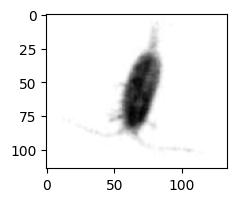

In [7]:
# dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_4.csv')
# img = io.imread(dfFoldTraining_1["filenames"][11838])
img = io.imread("0064-cop_calanoida_ptt_resized.png", as_gray=True)

plt.figure(figsize=(5,2))

plt.imshow(img,cmap='Greys_r')


In [8]:
img.shape

(114, 134)

In [9]:
row = img.shape[0]
col = img.shape[1] # size of image
fmax = 0.327 # maximum frequency

k = np.sqrt(2) #frequency ratio or factor for selecting filter frequencies

p = 0.5 # crossing point between two consecutive filters, default 0.5
# pf = np.sqrt(0.99) #energy to include in the filters

u = 6 #number of frequencies
v = 8 #number of orientation

GaborFilterBank = createASetOfGaborFilters(fmax, k, p, u, v, row, col)

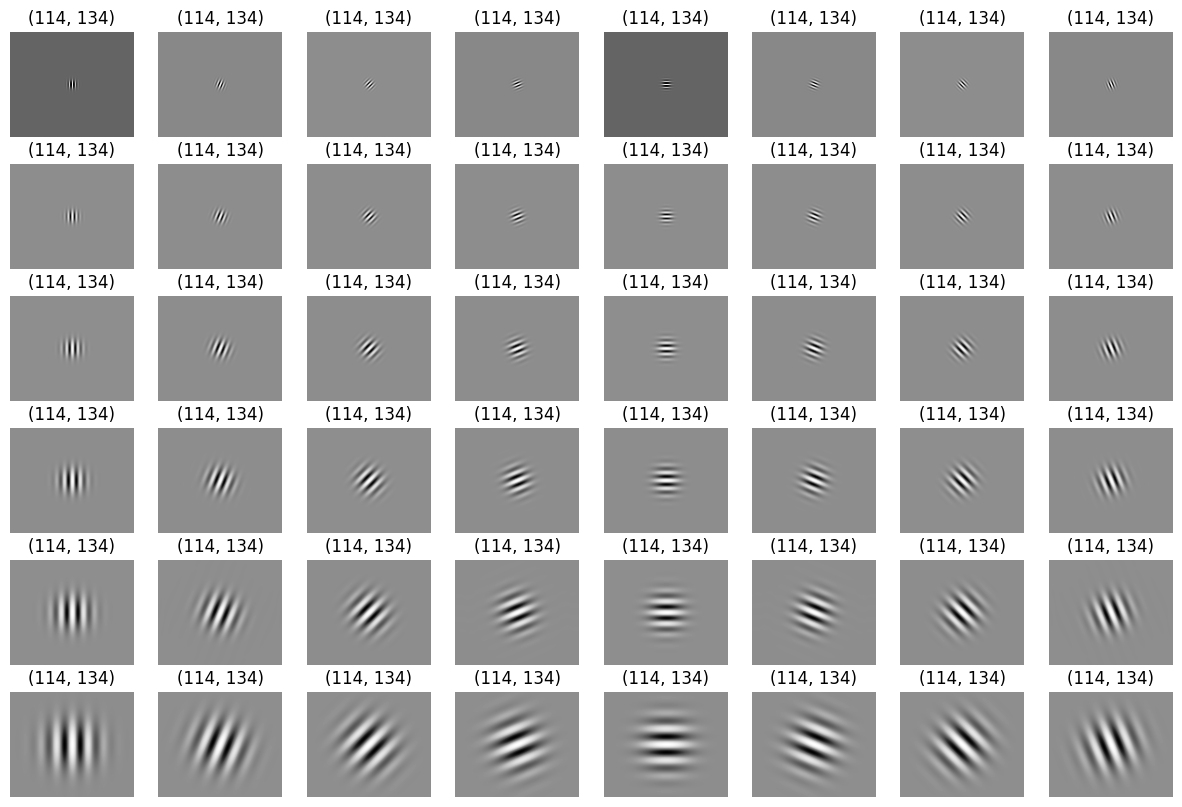

In [10]:
plt.figure(figsize=(15,10)) 
for i in range(len(GaborFilterBank)):
    ax = plt.subplot(u, v, i + 1)
    ax.imshow(np.real(GaborFilterBank[i].SpatialDomainGaborFilter),cmap='Greys_r')
    label = str(np.real(GaborFilterBank[i].SpatialDomainGaborFilter).shape)
    ax.set_title(label)
    ax.axis("off")

In [ ]:
for i in range(len(GaborFilterBank)):
    GaborFilterBank[i].show_parameters()

In [19]:
np.int32(GaborFilterBank[0].frequency)

0

In [11]:
def get_Gabor_filters_by_frequency(GaborFilterBank, FrequencyValue, NumberOfOrientations):

    GaborFilterSubsetByFrequency = [None]*NumberOfOrientations
    
    j=0
    
    for i in range(len(GaborFilterBank)):
        if GaborFilterBank[i].frequency == FrequencyValue:
            GaborFilterSubsetByFrequency[j] = GaborFilterBank[i]
            j += 1
            if j == NumberOfOrientations:
                return GaborFilterSubsetByFrequency
            
    return GaborFilterSubsetByFrequency

def get_max_frequency_of_Gabor_filter_bank(GaborFilterBank):
       
    MaxFrequency = 0
    
    for i in range(len(GaborFilterBank)):
        if GaborFilterBank[i].max_frequency > MaxFrequency:
            MaxFrequency = GaborFilterBank[i].max_frequency
            
    return MaxFrequency

In [11]:
a = get_Gabor_filters_by_frequency(GaborFilterBank, 0.327, 8)

In [12]:
a[2].show_parameters()

This Gabor filter has: 
 	 frequency: 0.327 
	 orientation: 0.7853981633974483 
	 max frequency: 0.46071840623279786 
	 Gaussian envelope: [11. 51.  9. 43.] 
	 shape on frequency domain: (35, 41) 
	 shape on spatial domain: (114, 134)


In [13]:
get_max_frequency_of_Gabor_filter_bank(GaborFilterBank)

0.46071840623279786

In [24]:
class GaborFilterResponse:
    # constructor
    def __init__(self, **kwargs):
        # private members
        self.__Zoom = None
        self.__ActualZoom = None
        self.__Method = None
        self.__Frequency = None # 
        self.__Response = None # 
        self.__ResponseSize = None # 

    @property # first decorate the getter method
    def zoom(self): # This getter method name is *the* name
        return self.__Zoom
    @zoom.setter    # the property decorates with `.setter` now
    def zoom(self, value):   # name, e.g. "attribute", is the same
        self.__Zoom = value   # the "value" name isn't special
    
    @property 
    def actual_zoom(self): 
        return self.__ActualZoom
    @actual_zoom.setter 
    def actual_zoom(self, value):   
        self.__ActualZoom = value
        
    @property 
    def FilterMethod(self): 
        return self.__Method
    @FilterMethod.setter 
    def FilterMethod(self, value):   
        self.__Method = value   
        
    @property 
    def frequency(self): 
        return self.__Frequency
    @frequency.setter 
    def frequency(self, value):   
        self.__Frequency = value   

    @property 
    def FilteredResponse(self): 
        return self.__Response
    @FilteredResponse.setter 
    def FilteredResponse(self, value):   
        self.__Response = value   

    @property 
    def SizeOfResponse(self): 
        return self.__ResponseSize
    @SizeOfResponse.setter 
    def SizeOfResponse(self, value):   
        self.__ResponseSize = value   
        
    def show_parameters(self):
        print("This Gabor filter has: \n", "\t frequency:",self.frequency,
                                            "\n\t zoon value:", self.zoom,
                                            "\n\t actual zoon value:", self.actual_zoom,
                                            "\n\t method of filtering:", self.FilterMethod,                        
                                            "\n\t shape on Filtered Response:", self.FilteredResponse.shape,             
                                            "\n\t shape of Filtered Response:", self.SizeOfResponse)
        
    def filter_an_image_with_a_set_of_Gabor_filters(self, FilteredImage, FrequencyValue, NumberOfOrientations, arrMN, Method=0, FilterDomain=1):
                
        self.FilterMethod = Method

        if self.FilterMethod == 0:
            self.zoom = 1
            self.actual_zoom = [1, 1]
            self.SizeOfResponse = arrMN
            
            
        if FilterDomain == 1:
             
            self.frequency = FrequencyValue

            GaborFilterSubsetByFrequency = get_Gabor_filters_by_frequency(GaborFilterBank, FrequencyValue, NumberOfOrientations)

            # zero memory for filter responses when filtering all points with original resolution
            if self.FilterMethod == 0:
                self.FilteredResponse = np.zeros((NumberOfOrientations, arrMN[1], arrMN[0]), dtype=np.complex_)

            for j in range(NumberOfOrientations):

                envelope = GaborFilterSubsetByFrequency[j].envelope

                # method 0 (full size responses)
                if self.FilterMethod == 0:

                    f2_ = np.zeros((arrMN[1] , arrMN[0]), dtype=np.complex_)

                    self.zoom = 1

                    lx = envelope[1] - envelope[0];
                    ly = envelope[3] - envelope[2];

                    # coordinates for the filter area in filtered fullsize image
                    xx = np.int32(np.mod( np.arange(0, lx + 1) + envelope[0] + arrMN[0] , arrMN[0] ) + 1) - 1;
                    yy = np.int32(np.mod( np.arange(0, ly + 1) + envelope[2] + arrMN[1] , arrMN[1] ) + 1) - 1;

                    fs = np.zeros((len(yy),len(xx)), dtype=np.complex_)

                    for y in range(len(yy)):
                        for x in range(len(xx)):
                            xf2 = xx[x] 
                            yf2 = yy[y] 
                            fs[y,x] = FilteredImage[yf2,xf2]


                    multifsgb = np.multiply(GaborFilterSubsetByFrequency[j].FrequencyDomainGaborFilter, fs)

                    for y in range(len(yy)):
                        for x in range(len(xx)):
                            xf2 = xx[x] 
                            yf2 = yy[y] 
                            f2_[yf2,xf2] = multifsgb[y,x]

                    self.FilteredResponse[j] = np.fft.ifftshift( np.fft.ifft2(f2_) )


In [26]:
def create_a_set_of_Gabor_filtered_responses(Image, GaborFilterBank, Method=0, FilterDomain=1, MaxZoom=0):  
       
    if FilterDomain == 1:
        # perform the filtering
        FilteredImage = np.fft.fft2(np.fft.ifftshift(img_as_float(Image)))

        #the loop for calculating responses at all frequencies

        # Get all values of frequencies from bank of Gabor filters
        ListOfrequencies = np.zeros(len(GaborFilterBank))
        for i in range(len(GaborFilterBank)):
            ListOfrequencies[i] = GaborFilterBank[i].frequency
        ListOfrequencies = np.unique(ListOfrequencies)
        ListOfrequencies[::-1].sort()

        NumberOfOrientations = np.int32(len(GaborFilterBank) / len(ListOfrequencies[::-1]))

        ListOfGaborFilterredResponses = [None]*len(ListOfrequencies)
        
        arrMN = np.array([Image.shape[1], Image.shape[0]])
            
        for i in range(len(ListOfrequencies)):   
            FrequencyValue = ListOfrequencies[i]
            GaborFilterResponseIJ = GaborFilterResponse()
            GaborFilterResponseIJ.filter_an_image_with_a_set_of_Gabor_filters(FilteredImage, FrequencyValue, NumberOfOrientations, arrMN)

            ListOfGaborFilterredResponses[i] = GaborFilterResponseIJ

    return ListOfGaborFilterredResponses

In [27]:
fResp = create_a_set_of_Gabor_filtered_responses(img, GaborFilterBank)

In [28]:
fResp[0].show_parameters()

This Gabor filter has: 
 	 frequency: 0.327 
	 zoon value: 1 
	 actual zoon value: [1, 1] 
	 method of filtering: 0 
	 shape on Filtered Response: (8, 114, 134) 
	 shape of Filtered Response: [134 114]


In [29]:
fResp[2].show_parameters()

This Gabor filter has: 
 	 frequency: 0.16349999999999998 
	 zoon value: 1 
	 actual zoon value: [1, 1] 
	 method of filtering: 0 
	 shape on Filtered Response: (8, 114, 134) 
	 shape of Filtered Response: [134 114]


In [ ]:
def convert_response_to_matrix(ListOfFilteredResponses, normalize=1):
    

In [38]:
fResp[0].FilteredResponse.shape

(8, 114, 134)

In [42]:
type(fResp[0].FilteredResponse)

numpy.ndarray

In [39]:
normalize = 0
NumberOfOrientations = fResp[0].FilteredResponse.shape[0]
NumberOfFrequencies = len(fResp)

n = fResp[0].FilteredResponse.shape

In [44]:
meh = np.zeros((n[1],n[2], NumberOfFrequencies * NumberOfOrientations), dtype=np.complex_)

i=0
u=0


In [45]:
meh[:,:,(i-1)*NumberOfFrequencies+(u-1) + 1] = fResp[i].FilteredResponse[u,:,:]

In [101]:
type(fResp[0].FilteredResponse.shape)

tuple

In [185]:
normalize = 1
NumberOfOrientations = fResp[0].FilteredResponse.shape[0]
NumberOfFrequencies = len(fResp)

n = fResp[0].FilteredResponse.shape

# handle case with responses from all points
if len(n) == 3:

  meh = np.zeros((n[1],n[2], NumberOfFrequencies * NumberOfOrientations), dtype=np.complex_)
  
  for i in range(NumberOfFrequencies):
    for u in range(NumberOfOrientations):
      meh[:,:,i*NumberOfOrientations + u] = np.copy(fResp[i].FilteredResponse[u,:,:])

  if normalize > 0:
    mehTemporary = np.copy(meh)
    mehSub = np.einsum('kli->lik', 1.0 / np.tile(np.sqrt(np.sum(np.square(np.abs(mehTemporary)), axis=2)), [NumberOfFrequencies * NumberOfOrientations,1,1]))
    meh = np.multiply(mehSub, mehTemporary)

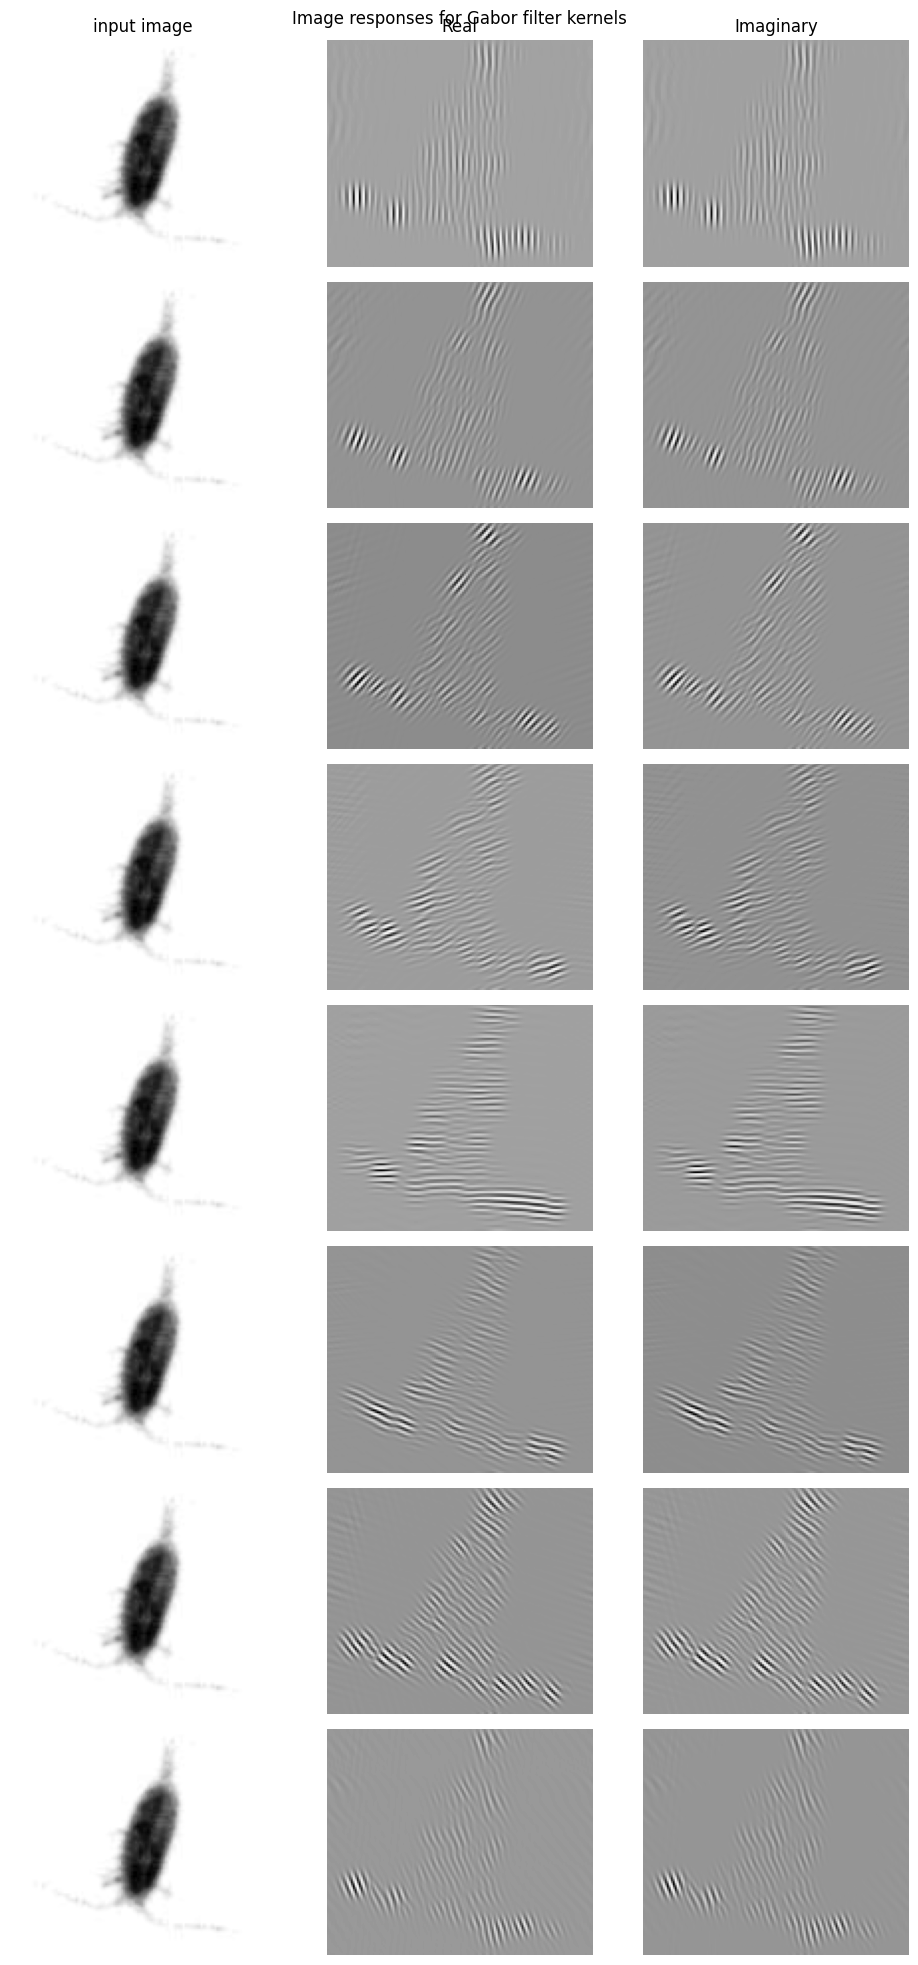

In [211]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(10, 20))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

# Plot original images
for i, ax in zip(range(8), axes[:, 0]):
    ax.imshow(img, cmap='Greys_r')
    if i == 0:
        ax.set_title("input image")
    ax.axis('off')

for i, ax in zip(range(8), axes[:, 1]):
    ax.imshow(np.real(meh[:,:,i]),cmap='Greys_r')
    if i == 0:
        ax.set_title("Real")
    ax.axis('off')

for i, ax in zip(range(8), axes[:, 2]):
    ax.imshow(np.imag(meh[:,:,i]),cmap='Greys_r')
    if i == 0:
        ax.set_title("Imaginary")
    ax.axis('off')

fig.tight_layout()

plt.show()

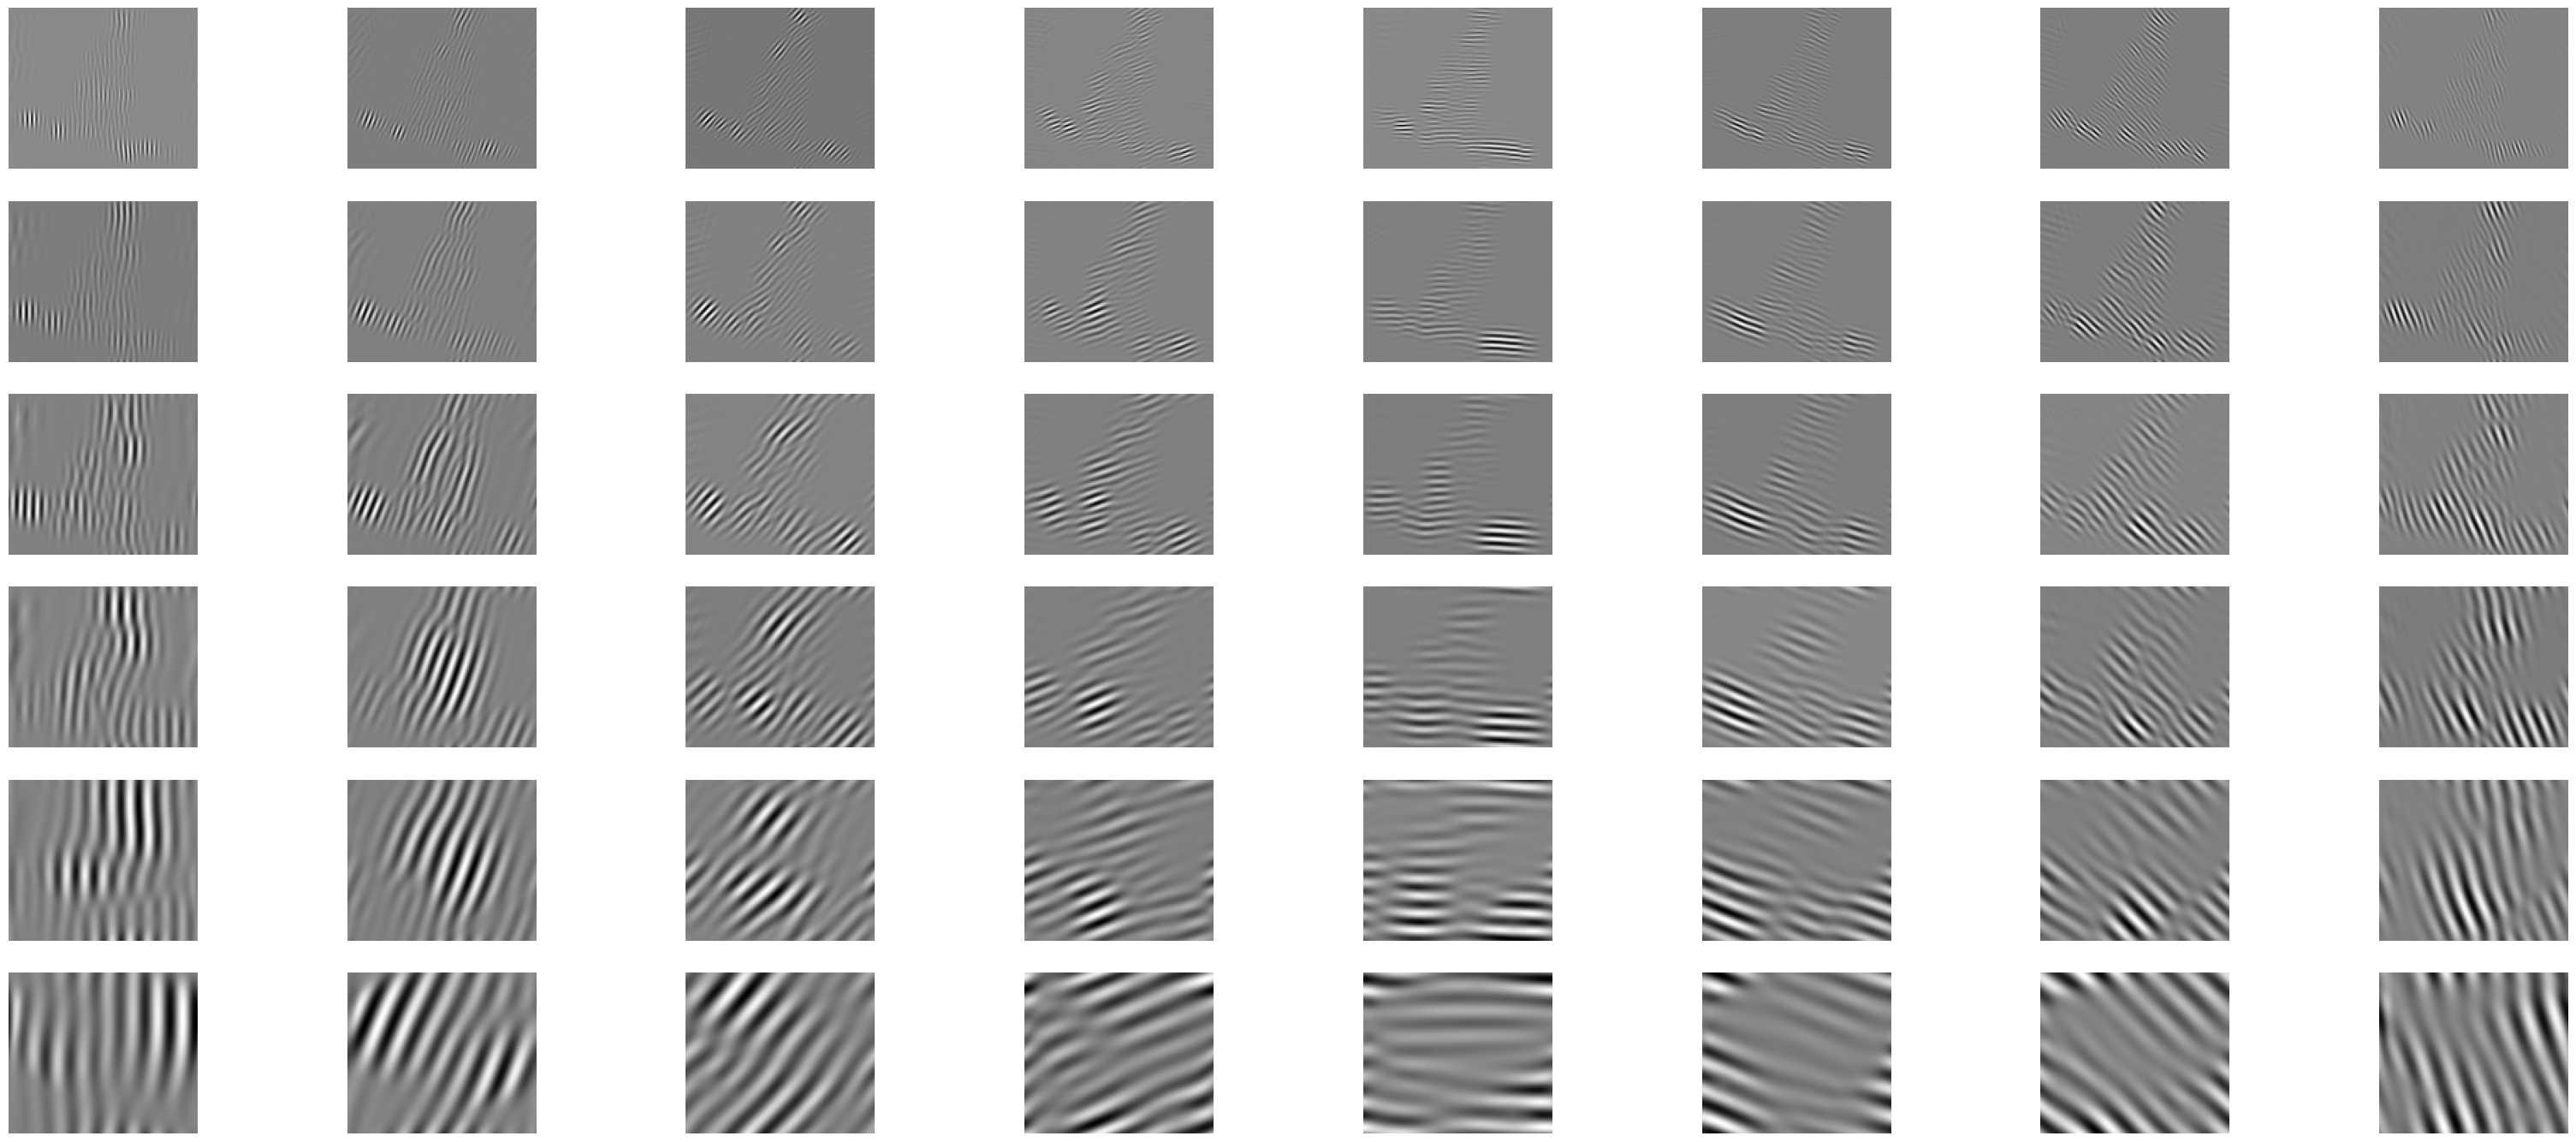

In [218]:
# visualization
plt.figure(figsize=(40,20)) 
for i in range(meh.shape[2]):
    ax = plt.subplot(u, v, i + 1)
    ax.imshow(np.real(meh[:,:,i]))
    ax.axis("off")



In [ ]:
def createSetOfGarborFilters(row=43, col=43):

    fmax = 0.327 # maximum frequency

    k = np.sqrt(2) #frequency ratio or factor for selecting filter frequencies
    
    p = 0.5 # crossing point between two consecutive filters, default 0.5
    # pf = np.sqrt(0.99) #energy to include in the filters
    
    u = 6 #number of frequencies
    v = 8 #number of orientation
    
    gamma, eta = sg_solvefilterparams(k, p, u, v) # smoothing parameters
    
    # gamma = np.sqrt(2)
    # eta = np.sqrt(2)
    
    arrFreqs = np.zeros(u) # store frequencies of filters 
    dMaxFHigh = 0 # store maximum frequency of all filter bank
    arrFHighs = np.zeros(u * v) # store maximum frequency of a filter bank
    arrOries = np.zeros(v) # store orientations of filters 
    arrFreqGaborFilters = [None] * u * v # store list of Gabor filters on frequency domain
    arrSpatGaborFilters = [None] * u * v # store list of Gabor filters on spatial domain
    arrEnvelopes = np.zeros((u * v, 4))
    
    for i in range(0,u):

        fu = fmax/k**i # frequency of the filter
        
        arrFreqs[i] = fu
        
        for j in range(0,v):
            theta = j/v*np.pi; # orientation of the filter 
            
            FreqGaborFilter, envelope, fhigh = computeAGaborFilter(fu, theta, gamma, eta, row, col) 
            
            SpatGaborFilters = transformtoSpatialGaborFiler(FreqGaborFilter, envelope, row, col) # for visualization
                  
            if fhigh > dMaxFHigh:
                dMaxFHigh = fhigh
            
            # arrFreqs[i * v + j] = fu
            arrFHighs[i * v + j] = fhigh
            arrEnvelopes[i * v + j] = envelope
            # arrOries[i * v + j] = theta
            arrOries[j] = theta
            arrFreqGaborFilters[i * v + j] = FreqGaborFilter
            arrSpatGaborFilters[i * v + j] = SpatGaborFilters # for visualization
            
            # display(envelope)
            # print(i,j, i * v + j)
        
    return arrFreqs, dMaxFHigh, arrFHighs, arrOries, arrEnvelopes, arrFreqGaborFilters, arrSpatGaborFilters

In [131]:
# gabor filter

def createGaborfilterbank(m=39, n=39):
    garray = []
    fmax = 0.327 # maximum frequency
    gamma = np.sqrt(2)
    eta = np.sqrt(2)
    
    gamma = 0.5
    eta = 0.5
    
    u = 6 #number of frequencies
    v = 8 #number of orientation

    for i in range(0,u):

        fu = fmax/np.sqrt(2)**(i); # frequency
        alpha = fu/gamma;
        beta = fu/eta;

        for j in range(0,v):
            theta = j/v*np.pi; # orientation 

            x, y = np.meshgrid(np.arange(1,n+1,1), np.arange(1,m+1,1))

            xenvolope  =  (x-((m+1)/2))*np.cos(theta) + (y-((n+1)/2))*np.sin(theta);
            yenvolope  = -(x-((m+1)/2))*np.sin(theta) + (y-((n+1)/2))*np.cos(theta);
            
            gfilter = np.transpose(
                                (fu**2/(np.pi*gamma*eta))*np.exp(-((alpha**2)*(xenvolope**2) + 
                              (beta**2)*(yenvolope**2)))*np.exp(1j*2*np.pi*fu*xenvolope)
                                    );

            garray.append(gfilter);

    plt.figure(figsize=(15,10))

    for i in range(48):    
        ax = plt.subplot(6,8,i+1)
        # ax.set_title(label)
        plt.imshow(np.real(garray[i]),cmap='Greys_r')
        plt.axis("off")  
        
    return garray

def computeGaborfeatures(image, kernels):
    feats = []
    filteredimg = []
    
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, np.abs(kernel), mode='wrap')
            
        feats.append(filtered.mean())
        feats.append(filtered.std())
        
        filteredimg.append(filtered)
        
    return feats, filteredimg

In [5]:
def sg_solvefilterparams(k, p, m, n):

    gamma = solvegamma(k, p);
    eta = solveeta(n, p);

    return gamma, eta


def solvegamma(k,p):

    gamma = 1.0 / np.pi * np.sqrt(-np.log(p)) * (k + 1) / (k - 1);

    return gamma


def solvek(gamma,p):

    x = 1.0 / (gamma * np.pi)*np.sqrt(-np.log(p));
    k = (1 + x) / (1 - x);
    
    return k


def solvep(gamma,k):

    p = np.exp(- (gamma * np.pi * (k - 1) / (k + 1))**2);
    
    return p


def solveeta(n,p):

    ua = np.pi / n / 2; # ua based on approximation

    eta = 1.0 / np.pi * np.sqrt(-np.log(p)) / ua;
    
    return eta


In [6]:
def norminv(p,mu,sigma):
    
    x0 = np.multiply( -np.sqrt(2), (erfcinv(2 * p)) );
    x = np.multiply(sigma, x0) + mu;
    
    return x

In [7]:
def compute_fhigh(f0, a, b):
    
    d = f0;

    if b > a:

      foo = -( (a**2) * d )/(a**2 - b**2);

      if foo < a:
        fhigh2 = np.sqrt( (d + foo)**2 + (b/a * np.sqrt(a**2 - foo**2))**2 );
      else:
        fhigh2 = d + a;
    
    else:
        fhigh2 = d + a; 

    if fhigh2 > 0.5:
      fhigh2 = 0.5; 

    return fhigh2

In [8]:
def ellipsoid_envelope_point(a,b,c):

    x=(c*(a**2))/np.sqrt(b**2+c**2*a**2)
    y=b/a*np.sqrt(a**2-x**2);
    
    return np.array([x,y])

In [9]:
def accurate_envelope_f(f0,a,b,theta):

    if np.mod(theta, np.pi/2)!=0:

        # solve points with slopes -tan(pi/2-theta) and tan(theta)
        x1y1 = ellipsoid_envelope_point(a,b,-np.tan(np.pi/2-theta))
        x2y2 = ellipsoid_envelope_point(a,b,np.tan(theta))
        
        envelope = np.array([x1y1, -x1y1, x2y2, -x2y2])
    
        # shift by f0
        envelope = envelope + np.tile([f0, 0],[4,1])

        # rotate by theta
        envelope = np.matmul(envelope, np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]))

        xmin = min(envelope[:,0]);
        xmax = max(envelope[:,0]);
        ymin = min(envelope[:,1]);
        ymax = max(envelope[:,1]);

        envelope=np.real([xmin, xmax, ymin, ymax])

    else: 

        envelope = np.array([[f0-a, 0], [f0+a, 0] , [f0, b], [f0, -b]])
        
        envelope = np.matmul(envelope, np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]))
        
        xmin = min(envelope[:,0]);
        xmax = max(envelope[:,0]);
        ymin = min(envelope[:,1]);
        ymax = max(envelope[:,1]);
        
        envelope=np.real([xmin, xmax, ymin, ymax])

    return envelope
    

In [10]:
def computeAGaborFilter(f0, theta, gamma, eta, Nx, Ny):
    
    pf = np.sqrt(0.99) #energy to include in the filters
    alpha = f0 / gamma
    beta = f0 / eta
    
    # accurate rectangular envelope
    majenv = norminv(np.array([1-pf, 1+pf])/2,0,f0/(np.sqrt(2)*np.pi*gamma))
    minenv = norminv(np.array([1-pf, 1+pf])/2,0,f0/(np.sqrt(2)*np.pi*eta))
    
    fhigh = compute_fhigh(f0,majenv[1],minenv[1])
    
    envelope = accurate_envelope_f(f0,majenv[1],minenv[1],theta)
    
    envelope[:2] = envelope[:2] * Nx
    envelope[-2:] = envelope[-2:] * Ny
    
    envelope = np.array([np.floor(envelope[0]), np.ceil(envelope[1]), np.floor(envelope[2]), np.ceil(envelope[3])])
    
    nx = np.arange(envelope[0], envelope[1] + 1, 1, dtype=int)
    ny = np.arange(envelope[2], envelope[3] + 1, 1, dtype=int)
    
    u = nx/Nx; #frequencies that bank contains
    v = ny/Ny;
    
    U, V = np.meshgrid(u,v)
    
    Uenvelope =  (np.add(-U * np.sin(theta), V * np.cos(theta)))**2 / beta**2
    Venvelope =  (np.add(U * np.cos(theta), V * np.sin(theta) - f0))**2 / alpha**2
    
    gf = np.exp( -(np.pi**2) * np.add(Uenvelope,Venvelope) )
    
    return gf, envelope, fhigh
    

In [11]:
def transformtoSpatialGaborFiler(FrequencyGaborFilter, envelope, row, col):
    
    M1 = col
    M2 = row
    
    lx = envelope[1] - envelope[0];
    ly = envelope[3] - envelope[2];
    
    xx = np.int32(np.mod( np.arange(0,lx + 1) + envelope[0] + M1 , M1 ) + 1)-1;
    yy = np.int32(np.mod( np.arange(0,ly + 1) + envelope[2] + M2 , M2 ) + 1)-1;
    
    f2_ = np.zeros((M2,M1), dtype=np.float64)
    
    for y in range(0,len(yy)):
        for x in range(0,len(xx)):
            xf2 = xx[x] 
            yf2 = yy[y] 

            f2_[yf2,xf2] = FrequencyGaborFilter[y,x]
            
    f2 = np.fft.ifftshift( np.fft.ifft2(f2_) )
    
    return f2

In [12]:
def createSetOfGarborFilters(row=43, col=43):

    fmax = 0.327 # maximum frequency

    k = np.sqrt(2) #frequency ratio or factor for selecting filter frequencies
    
    p = 0.5 # crossing point between two consecutive filters, default 0.5
    # pf = np.sqrt(0.99) #energy to include in the filters
    
    u = 6 #number of frequencies
    v = 8 #number of orientation
    
    gamma, eta = sg_solvefilterparams(k, p, u, v) # smoothing parameters
    
    # gamma = np.sqrt(2)
    # eta = np.sqrt(2)
    
    arrFreqs = np.zeros(u) # store frequencies of filters 
    dMaxFHigh = 0 # store maximum frequency of all filter bank
    arrFHighs = np.zeros(u * v) # store maximum frequency of a filter bank
    arrOries = np.zeros(v) # store orientations of filters 
    arrFreqGaborFilters = [None] * u * v # store list of Gabor filters on frequency domain
    arrSpatGaborFilters = [None] * u * v # store list of Gabor filters on spatial domain
    arrEnvelopes = np.zeros((u * v, 4))
    
    for i in range(0,u):

        fu = fmax/k**i # frequency of the filter
        
        arrFreqs[i] = fu
        
        for j in range(0,v):
            theta = j/v*np.pi; # orientation of the filter 
            
            FreqGaborFilter, envelope, fhigh = computeAGaborFilter(fu, theta, gamma, eta, row, col) 
            
            SpatGaborFilters = transformtoSpatialGaborFiler(FreqGaborFilter, envelope, row, col) # for visualization
                  
            if fhigh > dMaxFHigh:
                dMaxFHigh = fhigh
            
            # arrFreqs[i * v + j] = fu
            arrFHighs[i * v + j] = fhigh
            arrEnvelopes[i * v + j] = envelope
            # arrOries[i * v + j] = theta
            arrOries[j] = theta
            arrFreqGaborFilters[i * v + j] = FreqGaborFilter
            arrSpatGaborFilters[i * v + j] = SpatGaborFilters # for visualization
            
            # display(envelope)
            # print(i,j, i * v + j)
        
    return arrFreqs, dMaxFHigh, arrFHighs, arrOries, arrEnvelopes, arrFreqGaborFilters, arrSpatGaborFilters

In [13]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_4.csv')
dfFoldTraining_1.index[dfFoldTraining_1['short_filenames'] == "0064-cop_calanoida_ptt.png"].tolist()

[11838]

(-0.5, 133.5, 133.5, -0.5)

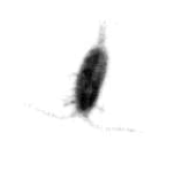

In [14]:
img = io.imread(dfFoldTraining_1["filenames"][11838])

plt.figure(figsize=(5,2))

plt.imshow(img,cmap='Greys_r')

plt.axis("off") 

In [15]:
img.shape

(134, 134)

In [16]:
arrFreqs, dMaxFHigh, arrFHighs, arrOries, arrEnvelopes, arrFreqGaborFilters, arrSpatGaborFilters = createSetOfGarborFilters(img.shape[0], img.shape[1])

<Figure size 1500x1000 with 0 Axes>

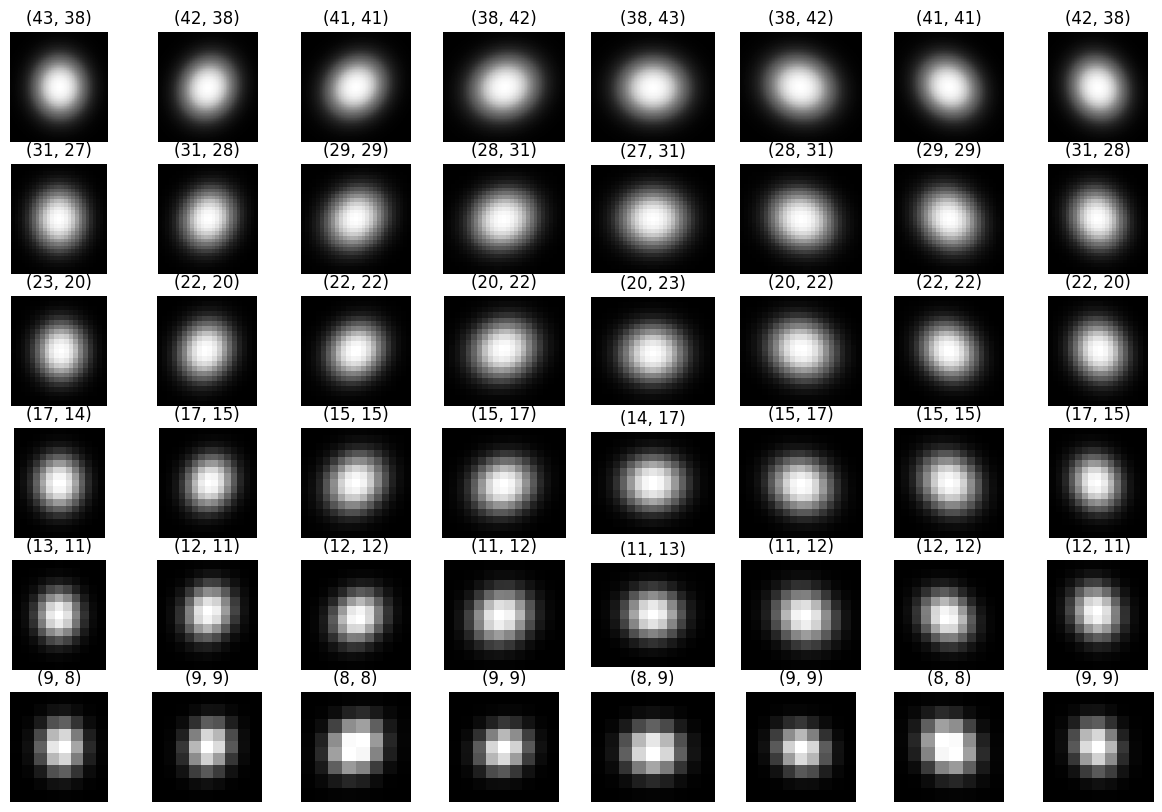

<Figure size 1500x1000 with 0 Axes>

In [148]:
plt.figure(figsize=(15,10))
for i in range(48):    
    ax = plt.subplot(6,8,i+1)
    # ax.set_title(label)
    plt.imshow(np.real(arrFreqGaborFilters[i]),cmap='Greys_r')
    label = str(np.real(arrFreqGaborFilters[i]).shape)
    ax.set_title(label)
    plt.axis("off") 
    
plt.figure(figsize=(15,10))

In [109]:
def filterImageWithASetOfGaborFilters2(img, arrFreqs, dMaxFHigh, arrFHighs, arrOries, arrEnvelopes, arrFreqGaborFilters, arrCustomPoints=[], dMMaxZoom=0):
    arrMN = np.array([img.shape[1], img.shape[0]])
    arrMZooms = np.zeros(len(arrFreqs))
    arrMRespSize = np.zeros((len(arrFreqs), arrMN.size), dtype=object)
    arrMActualZoom = np.zeros((len(arrFreqs), arrMN.size), dtype=object)
    
    # loop through frequencies
    for idxFreq in range(len(arrFreqs)):
        dZoom = 0.5 / arrFHighs[idxFreq * len(arrOries)]

        if dMMaxZoom > 0 and dZoom > dMMaxZoom:
            dZoom = dMMaxZoom

        if dZoom < 1:
            printf('Zoom factor smaller than 1, wtf?\n');
            dZoom = 1;

        arrMZooms[idxFreq] = dZoom

        # the responsesize is always wanted to be divisible by two
        arrMRespSize[idxFreq] = np.int32(np.round(arrMN / dZoom / 2.0) * 2.0); 

        # actual zoom factor
        arrMActualZoom[idxFreq] = arrMN / arrMRespSize[idxFreq];

    # perform the filtering
    fimg = np.fft.fft2(np.fft.ifftshift(img_as_float(img)))

    
    arrMFreqs = np.zeros(len(arrFreqs))
    arrMResps = [None]*len(arrFreqs)
    arrMFreqZooms = np.zeros(len(arrFreqs))
    
    # loop through frequencies
    for idxFreq in range(len(arrFreqs)):
        f0 = arrFreqs[idxFreq]

        arrMFreqs[idxFreq] = f0

        # zero memory for filter responses, each frequency is of different size now 
        if not arrCustomPoints:
            arrMResps[idxFreq] = np.zeros((len(arrOries), np.squeeze(arrMRespSize[idxFreq])[1], np.squeeze(arrMRespSize[idxFreq])[0]), dtype=np.complex_)
            
        # loop through orientations
        for idxOrien in range(len(arrOries)):
            
            a = arrEnvelopes[idxFreq * len(arrFreqs) + idxOrien]

            fhigh = arrFHighs[idxFreq * len(arrFreqs) + idxOrien]

            arrMFreqZooms[idxFreq] = arrMZooms[idxFreq]

            f2_ = np.zeros((arrMRespSize[idxFreq, 1] , arrMRespSize[idxFreq, 0]), dtype=np.complex_)
                      
            lx = a[1]-a[0];
            ly = a[3]-a[2];

            # coordinates for the filter area in filtered fullsize image
            xx = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMN[0] , arrMN[0] ) + 1) - 1;
            yy = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMN[1] , arrMN[1] ) + 1) - 1;

            # coordinates for the filter area in downscaled response image
            xx_z = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMRespSize[idxFreq, 0], arrMRespSize[idxFreq, 0]));
            yy_z = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMRespSize[idxFreq, 1], arrMRespSize[idxFreq, 1]));

            fs = np.zeros((len(yy),len(xx)), dtype=np.complex_)
            for y in range(0,len(yy)):
                for x in range(0,len(xx)):
                    xf2 = xx[x] 
                    yf2 = yy[y] 
                    fs[y,x] = fimg[yf2,xf2]

            multifsgb = np.multiply(arrFreqGaborFilters[idxFreq * len(arrFreqs) + idxOrien], fs)

            for y in range(0,len(yy_z)):
                for x in range(0,len(xx_z)):
                    xf2 = xx_z[x] 
                    yf2 = yy_z[y] 
                    f2_[yf2,xf2] = multifsgb[y,x]
            
            arrMResps[idxFreq][idxOrien] = np.divide(np.fft.ifftshift(np.fft.ifft2(f2_)), arrMActualZoom[idxFreq].prod())
    
    return arrMN, arrMZooms, arrMActualZoom, arrMRespSize, arrMFreqs, arrMFreqZooms, arrMResps

In [110]:
arrMN, arrMZooms, arrMActualZoom, arrMRespSize, arrMFreqs, arrMFreqZooms, arrMResps = filterImageWithASetOfGaborFilters2(img, arrFreqs, dMaxFHigh, arrFHighs, arrOries, arrEnvelopes, arrFreqGaborFilters)

In [111]:
arrMN = np.array([img.shape[1], img.shape[0]])
intMZoom = 1
arrMRespSize = arrMN.copy()
arrMActualZoom = [1 1];

# arrMZooms = np.zeros(len(arrFreqs))
# arrMRespSize = np.zeros((len(arrFreqs), arrMN.size), dtype=object)
# arrMActualZoom = np.zeros((len(arrFreqs), arrMN.size), dtype=object)

In [108]:
boolNormalize = 0

nf = len(arrMFreqs)
of = len(arrMResps[0])
n = arrMResps[0].ndim

print(nf, of, n)

try:

    # handle case with responses from all points
    if n == 3:
      meh = np.zeros(n(2),n(3),nf*of);

      for i in range(nf):
        for u in range(of)
          meh(:,:,(i-1)*of+(u-1) + 1)=r.freq{i}.resp(u,:,:);

      if boolNormalize > 0:
        meh=(1./repmat(sqrt(sum(abs(meh).^2,3)),[1,1,nf*of])).*meh;

except ValueError:
    print("Could not decipher response structure")

6 8 (8, 124, 124)


In [97]:
arrMActualZoom

array([[1.0806451612903225, 1.0806451612903225],
       [1.5227272727272727, 1.5227272727272727],
       [2.161290322580645, 2.161290322580645],
       [3.0454545454545454, 3.0454545454545454],
       [4.466666666666667, 4.466666666666667],
       [6.090909090909091, 6.090909090909091]], dtype=object)

In [99]:
for i in range(len(arrMFreqs)):
    print(arrMResps[i].shape)
    
    

(8, 124, 124)
(8, 88, 88)
(8, 62, 62)
(8, 44, 44)
(8, 30, 30)
(8, 22, 22)


In [18]:
arrMN = np.array([img.shape[1], img.shape[0]])
arrMZooms = np.zeros(len(arrFreqs))
dMMaxZoom = 0
arrMRespSize = np.zeros((len(arrFreqs), arrMN.size), dtype=object)
arrMActualZoom = np.zeros((len(arrFreqs), arrMN.size), dtype=object)

for idxFreq in range(len(arrFreqs)):
    dZoom = 0.5 / arrFHighs[idxFreq * len(arrOries)]
    
    if dMMaxZoom > 0 and dZoom > dMMaxZoom:
        dZoom = dMMaxZoom
    
    if dZoom < 1:
        printf('Zoom factor smaller than 1, wtf?\n');
        dZoom = 1;
        
    arrMZooms[idxFreq] = dZoom
    
    # print(dZoom, arrN)
    
    # the responsesize is always wanted to be divisible by two
    arrMRespSize[idxFreq] = np.int32(np.round(arrMN / dZoom / 2) * 2); 

    # actual zoom factor
    arrMActualZoom[idxFreq] = arrMN / arrMRespSize[idxFreq];
    
print(arrMZooms)

print(arrMRespSize)
print(arrMActualZoom)


# perform the filtering
fimg = np.fft.fft2(np.fft.ifftshift(img_as_float(img)))


# arrMFreqs = np.zeros(len(arrFreqs))
# arrCustomPoints = []

# for idxFreq in range(len(arrFreqs)):
#     f0 = arrFreqs[idxFreq]
    
#     arrMFreqs[idxFreq] = f0
    
#     # zero memory for filter responses, each frequency is of different size now 
#     if not arrCustomPoints
#         #m.freq{find}.resp=zeros(length(bank.freq{find}.orient),m.respSize(find,2),m.respSize(find,1))
        

[1.08526161 1.53479169 2.17052322 3.06958338 4.34104645 6.13916676]
[[124 124]
 [88 88]
 [62 62]
 [44 44]
 [30 30]
 [22 22]]
[[1.0806451612903225 1.0806451612903225]
 [1.5227272727272727 1.5227272727272727]
 [2.161290322580645 2.161290322580645]
 [3.0454545454545454 3.0454545454545454]
 [4.466666666666667 4.466666666666667]
 [6.090909090909091 6.090909090909091]]


In [19]:
arrEnvelopes

array([[ 25.,  62., -21.,  21.],
       [ 22.,  59.,  -4.,  37.],
       [ 11.,  51.,  11.,  51.],
       [ -4.,  37.,  22.,  59.],
       [-21.,  21.,  25.,  62.],
       [-37.,   4.,  22.,  59.],
       [-51., -11.,  11.,  51.],
       [-59., -22.,  -4.,  37.],
       [ 18.,  44., -15.,  15.],
       [ 15.,  42.,  -3.,  27.],
       [  8.,  36.,   8.,  36.],
       [ -3.,  27.,  15.,  42.],
       [-15.,  15.,  18.,  44.],
       [-27.,   3.,  15.,  42.],
       [-36.,  -8.,   8.,  36.],
       [-42., -15.,  -3.,  27.],
       [ 12.,  31., -11.,  11.],
       [ 11.,  30.,  -2.,  19.],
       [  5.,  26.,   5.,  26.],
       [ -2.,  19.,  11.,  30.],
       [-11.,  11.,  12.,  31.],
       [-19.,   2.,  11.,  30.],
       [-26.,  -5.,   5.,  26.],
       [-30., -11.,  -2.,  19.],
       [  9.,  22.,  -8.,   8.],
       [  7.,  21.,  -2.,  14.],
       [  4.,  18.,   4.,  18.],
       [ -2.,  14.,   7.,  21.],
       [ -8.,   8.,   9.,  22.],
       [-14.,   2.,   7.,  21.],
       [-1

In [118]:
arrMFreqs = np.zeros(len(arrFreqs))
arrCustomPoints = []
arrMResps = [None]*len(arrFreqs)
arrMFreqZooms = np.zeros(len(arrFreqs))
for idxFreq in range(0,1):
    print(idxFreq)
    f0 = arrFreqs[idxFreq]
    
    arrMFreqs[idxFreq] = f0
    
    # zero memory for filter responses, each frequency is of different size now 
    if not arrCustomPoints:
        arrMResps[idxFreq] = np.zeros((len(arrOries), np.squeeze(arrMRespSize[0])[1], np.squeeze(arrMRespSize[0])[0]))
        
        # loop through orientations
        for idxOrien in range(0,1):
            print(idxOrien)
            a = arrEnvelopes[idxFreq * len(arrFreqs) + idxOrien]
            
            fhigh = arrFHighs[idxFreq * len(arrFreqs) + idxOrien]
            
            arrMFreqZooms[idxFreq] = arrMZooms[idxFreq]
            
            f2_ = np.zeros((arrMRespSize[idxFreq, 1] , arrMRespSize[idxFreq, 0]), dtype=np.complex_)
            
            lx = a[1]-a[0];
            ly = a[3]-a[2];
            
            # coordinates for the filter area in filtered fullsize image
            xx = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMN[0] , arrMN[0] ) + 1) - 1;
            yy = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMN[1] , arrMN[1] ) + 1) - 1;
            
            # coordinates for the filter area in downscaled response image
            xx_z = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMRespSize[idxFreq, 0], arrMRespSize[idxFreq, 0]));
            yy_z = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMRespSize[idxFreq, 1], arrMRespSize[idxFreq, 1]));
            
            fs = np.zeros((len(yy),len(xx)), dtype=np.complex_)
            for y in range(0,len(yy)):
                for x in range(0,len(xx)):
                    xf2 = xx[x] 
                    yf2 = yy[y] 
                    fs[y,x] = fimg[yf2,xf2]
                    
            multifsgb = np.multiply(arrFreqGaborFilters[idxFreq * len(arrFreqs) + idxOrien], fs)
            
            for y in range(0,len(yy_z)):
                for x in range(0,len(xx_z)):
                    xf2 = xx_z[x] 
                    yf2 = yy_z[y] 
                    f2_[yf2,xf2] = multifsgb[y,x]
            
            arrMResps[idxFreq] = np.divide(np.fft.ifftshift( np.fft.ifft2(f2_) ), arrMActualZoom[idxFreq].prod())

0
0


In [24]:
arrMFreqs = np.zeros(len(arrFreqs))
arrCustomPoints = []
arrMResps = [None]*len(arrFreqs)
arrMFreqZooms = np.zeros(len(arrFreqs))
for idxFreq in range(len(arrFreqs)):
    f0 = arrFreqs[idxFreq]
    
    arrMFreqs[idxFreq] = f0
    
    # zero memory for filter responses, each frequency is of different size now 
    if not arrCustomPoints:
        arrMResps[idxFreq] = np.zeros((len(arrOries), np.squeeze(arrMRespSize[0])[1], np.squeeze(arrMRespSize[0])[0]))
        
        # loop through orientations
        for idxOrien in range(len(arrOries)):
            a = arrEnvelopes[idxFreq * len(arrFreqs) + idxOrien]
            
            fhigh = arrFHighs[idxFreq * len(arrFreqs) + idxOrien]
            
            arrMFreqZooms[idxFreq] = arrMZooms[idxFreq]
            
            f2_ = np.zeros((arrMRespSize[idxFreq, 1] , arrMRespSize[idxFreq, 0]), dtype=np.complex_)
            
            lx = a[1]-a[0];
            ly = a[3]-a[2];
            
            # coordinates for the filter area in filtered fullsize image
            xx = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMN[0] , arrMN[0] ) + 1) - 1;
            yy = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMN[1] , arrMN[1] ) + 1) - 1;
            
            # coordinates for the filter area in downscaled response image
            xx_z = np.int32(np.mod( np.arange(0, lx + 1) + a[0] + arrMRespSize[idxFreq, 0], arrMRespSize[idxFreq, 0]));
            yy_z = np.int32(np.mod( np.arange(0, ly + 1) + a[2] + arrMRespSize[idxFreq, 1], arrMRespSize[idxFreq, 1]));
            
            # filter the image
            fs = np.zeros((len(yy),len(xx)), dtype=np.complex_)
            for y in range(0,len(yy)):
                for x in range(0,len(xx)):
                    xf2 = xx[x] 
                    yf2 = yy[y] 
                    fs[y,x] = fimg[yf2,xf2]
            
            
            multifsgb = np.multiply(arrFreqGaborFilters[idxFreq * len(arrFreqs) + idxOrien], fs)
            
            for y in range(0,len(yy_z)):
                for x in range(0,len(xx_z)):
                    xf2 = xx_z[x] 
                    yf2 = yy_z[y] 
                    f2_[yf2,xf2] = multifsgb[y,x]
            
            # set the responses to response matrix and normalize amplitudes for the zoom factor
            arrMResps[idxFreq] = np.divide(np.fft.ifftshift( np.fft.ifft2(f2_) ), arrMActualZoom[idxFreq].prod())